In [1]:
import numpy as np
import pandas as pd
import os
import random

import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers
from tensorflow.keras.metrics import MeanIoU

In [724]:
input_dir = "./road/training/image_2/"
target_dir = "./road/training/gt_image_2/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".png")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

In [725]:
num_image_files = int(len(os.listdir(input_dir)))
print(f"Number of Training Examples: {num_image_files}")

num_mask_files = int(len(os.listdir(target_dir)))
print(f"Number of Training Examples: {num_mask_files}")

Number of Training Examples: 289
Number of Training Examples: 289


In [726]:
img_size = (128, 128)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(load_img(path, target_size=img_size))
    img = img.astype("uint8")
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (3,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

print(input_imgs.shape)
print(targets.shape)

(289, 128, 128, 3)
(289, 128, 128, 3)


In [727]:
# Integrate all pixels into a single list
all_pixels = targets.reshape(-1, 3)

# Find the unique RGB values of each pixel
unique_rgb_values = np.unique(all_pixels, axis=0)

print(unique_rgb_values)

[[  0   0   0]
 [  0   0 255]
 [255   0   0]
 [255   0 255]]


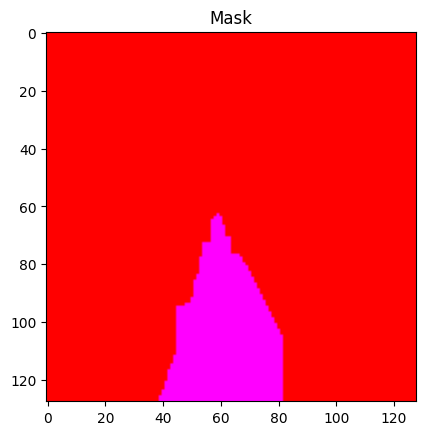

In [728]:
plt.imshow(targets[0]/255.)
plt.title(f'Mask')
plt.show()

In [729]:
# Find the pixel corresponding to [255, 0, 255]
road_mask = np.all(targets == [255, 0, 255], axis=-1)

binary_road_mask = road_mask.astype("uint8")
binary_road_mask = binary_road_mask[..., np.newaxis]

binary_road_mask.shape

(289, 128, 128, 1)

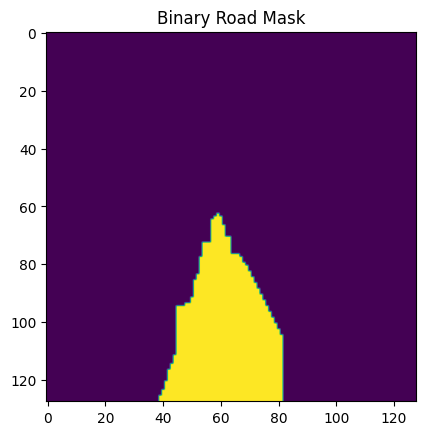

In [730]:
plt.imshow(binary_road_mask[0]/255.)
plt.title('Binary Road Mask')
plt.show()

In [731]:
num_val_samples = 70

input_imgs = input_imgs / 255.

train_input_imgs = input_imgs[:-num_val_samples]
train_targets = binary_road_mask[:-num_val_samples]
test_input_imgs = input_imgs[-num_val_samples:]
test_targets = binary_road_mask[-num_val_samples:]

In [732]:
np.save('./data/train_input_imgs.npy', train_input_imgs)
np.save('./data/train_targets.npy', train_targets)
np.save('./data/test_input_imgs.npy', test_input_imgs)
np.save('./data/test_targets.npy', test_targets)

In [2]:
train_input_imgs = np.load('./data/train_input_imgs.npy')
train_targets = np.load('./data/train_targets.npy')
test_input_imgs = np.load('./data/test_input_imgs.npy')
test_targets = np.load('./data/test_targets.npy')

In [3]:
print(train_input_imgs.shape)
print(train_targets.shape)

(219, 128, 128, 3)
(219, 128, 128, 1)


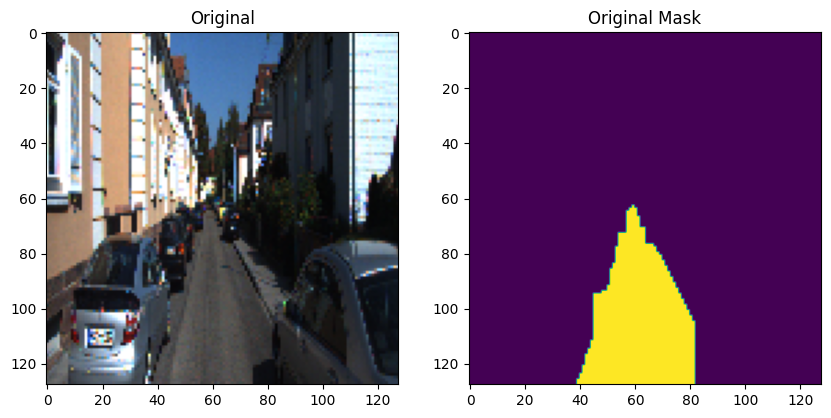

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))
ax[0].imshow(train_input_imgs[0])
ax[0].set_title("Original")

ax[1].imshow(train_targets[0]/255.)
ax[1].set_title("Original Mask")

plt.show()

In [736]:
import albumentations as A
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

import cv2

augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.RGBShift(r_shift_limit=1, g_shift_limit=1, b_shift_limit=1, p=0.5),

])

In [737]:
train_input_imgs = train_input_imgs.astype(np.float32)
train_targets = train_targets.astype(np.float32)

In [738]:
aug_test=augmentation_pipeline(image=train_input_imgs[0], mask=train_targets[0])
aug_image_example=aug_test["image"]
aug_mask_example=aug_test["mask"]

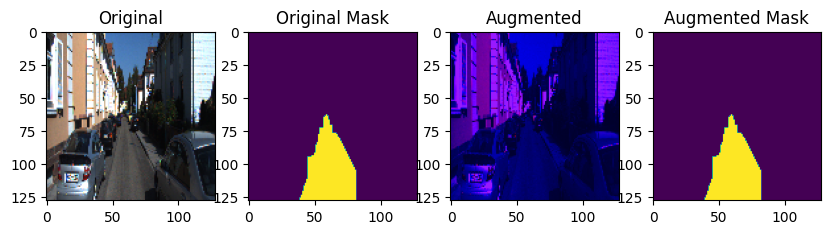

In [739]:
fig, ax = plt.subplots(1, 4, figsize=(10, 7))
ax[0].imshow(train_input_imgs[0])
ax[0].set_title("Original")

ax[1].imshow(train_targets[0])
ax[1].set_title("Original Mask")

ax[2].imshow(aug_image_example)
ax[2].set_title("Augmented")

ax[3].imshow(aug_mask_example)
ax[3].set_title("Augmented Mask")

plt.show()

In [741]:
random.seed(42)  # Fixing the random seed once
np.random.seed(42)

NewIMGS = 10  # Number of augmented images to generate per original image
augmented_images = []
augmented_masks = []

for i in range(len(train_input_imgs)):
    image = train_input_imgs[i]
    mask = train_targets[i]
    
    for j in range(NewIMGS):
        # Apply the augmentation pipeline
        augmented = augmentation_pipeline(image=image, mask=mask)

        augmented_images.append(augmented["image"])
        augmented_masks.append(augmented["mask"])

### Save Augmented Data

In [742]:
augmented_images = np.array(augmented_images)
np.save('./data/augmented_images.npy', augmented_images)
augmented_images.shape

(2190, 128, 128, 3)

In [743]:
augmented_masks = np.array(augmented_masks)
np.save('./data/augmented_masks.npy', augmented_masks)
augmented_masks.shape

(2190, 128, 128, 1)

### Load Augmented Data

In [5]:
augmented_images = np.load('./data/augmented_images.npy')
augmented_masks = np.load('./data/augmented_masks.npy')

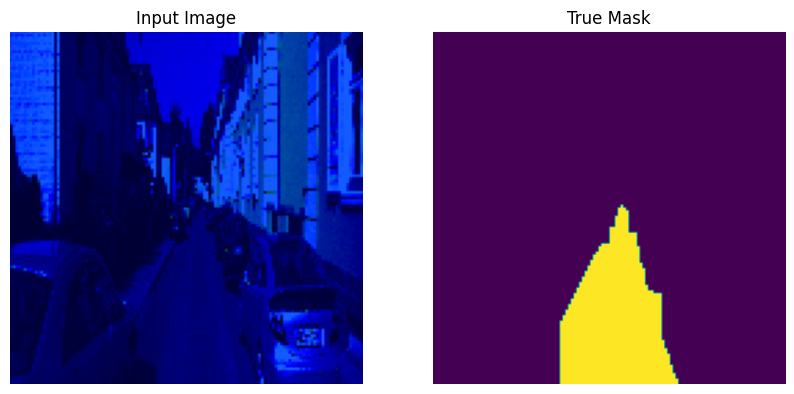

In [6]:
def display_sample(display_list):
    plt.figure(figsize = (10, 10))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    
    plt.show()
    
display_sample([augmented_images[0], augmented_masks[0]/255.])

In [14]:
# Shuffle the indices
np.random.seed(42)
shuffled_indices = np.random.permutation(len(augmented_images))

# Use the shuffled indices to shuffle both arrays
shuffled_data = augmented_images[shuffled_indices]
shuffled_masks = augmented_masks[shuffled_indices]

np.savez('./data/shuffled_data.npz', data=shuffled_data, masks=shuffled_masks)

In [15]:
#train_validation split
loaded_data = np.load('./data/shuffled_data.npz')
shuffled_data = loaded_data['data']
shuffled_masks = loaded_data['masks']

train_set_size = int(len(shuffled_data)*0.8)

X_train=shuffled_data[:train_set_size]
y_train=shuffled_masks[:train_set_size]
print(f'training set size {X_train.shape}')

X_val=shuffled_data[train_set_size:]
y_val=shuffled_masks[train_set_size:]
print(f'validation set size {X_val.shape}')

training set size (1752, 128, 128, 3)
validation set size (438, 128, 128, 3)


In [16]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    #x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(inputs)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=(128, 128), num_classes=1)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 256)       590080

### Train Base Segmentation Model

In [17]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/road_segmentation_base.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(X_train, y_train,
                    epochs=70,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/70
28/28 [==============================] - 16s 381ms/step - loss: 0.8163 - val_loss: 0.5323
Epoch 2/70
28/28 [==============================] - 6s 203ms/step - loss: 0.4410 - val_loss: 0.3404
Epoch 3/70
28/28 [==============================] - 5s 197ms/step - loss: 0.3506 - val_loss: 0.3693
Epoch 4/70
28/28 [==============================] - 5s 194ms/step - loss: 0.3036 - val_loss: 0.8136
Epoch 5/70
28/28 [==============================] - 5s 196ms/step - loss: 0.3042 - val_loss: 0.2485
Epoch 6/70
28/28 [==============================] - 5s 197ms/step - loss: 0.2453 - val_loss: 0.2296
Epoch 7/70
28/28 [==============================] - 6s 198ms/step - loss: 0.2368 - val_loss: 0.2068
Epoch 8/70
28/28 [==============================] - 5s 196ms/step - loss: 0.2081 - val_loss: 0.2673
Epoch 9/70
28/28 [==============================] - 5s 196ms/step - loss: 0.2137 - val_loss: 0.1732
Epoch 10/70
28/28 [==============================] - 5s 196ms/step - loss: 0.1936 - val_loss: 0.177

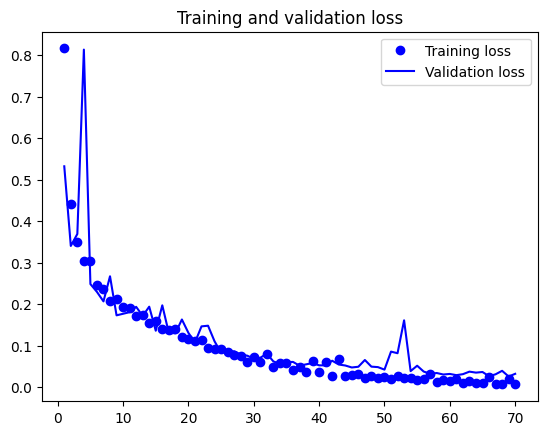

In [18]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [19]:
model = keras.models.load_model("./models/road_segmentation_base.keras")

In [20]:
test_image = test_input_imgs
ground_truth_mask = test_targets
print(test_image.shape)

(70, 128, 128, 3)


In [21]:
mask_pred = model.predict(test_image)
mask_pred.shape

3/3 [==============================] - 2s 271ms/step


(70, 128, 128, 1)

In [22]:
binary_predictions = (mask_pred > 0.5).astype(np.uint8)
print(binary_predictions.shape)
print(ground_truth_mask.shape)


(70, 128, 128, 1)
(70, 128, 128, 1)


In [23]:
# print the predicted and ground truth classification label
print(np.unique(binary_predictions))
print(np.unique(ground_truth_mask))

[0 1]
[0 1]


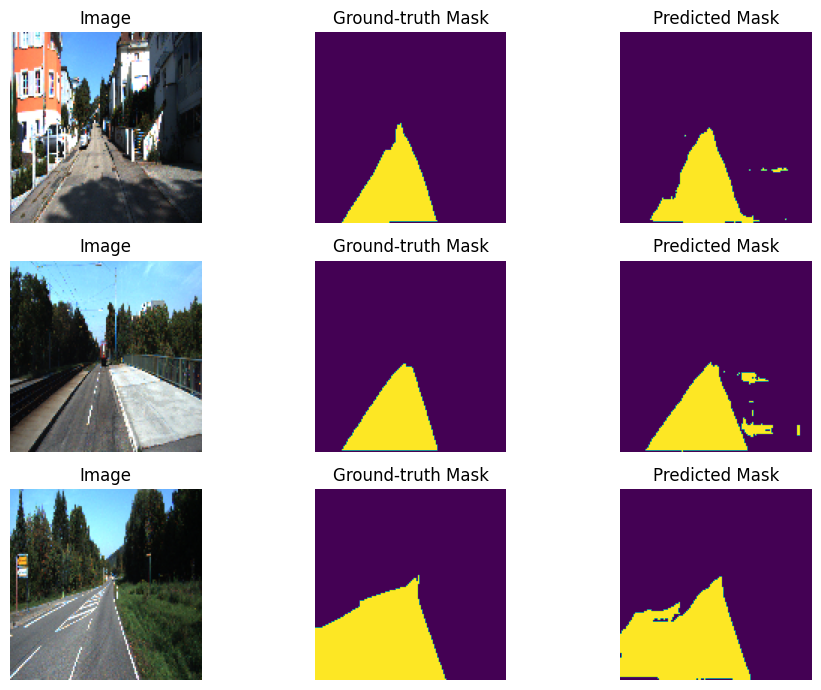

In [24]:
fig, ax = plt.subplots(3, 3, figsize=(10, 7))

indices = [0, 5, 10]

for plot_index, i in enumerate(indices):
    ax[plot_index, 0].imshow(test_image[i])
    ax[plot_index, 0].set_title("Image")
    ax[plot_index, 0].axis("off")


    ax[plot_index, 1].imshow(ground_truth_mask[i])
    ax[plot_index, 1].set_title("Ground-truth Mask")
    ax[plot_index, 1].axis("off")


    ax[plot_index, 2].imshow(binary_predictions[i])
    ax[plot_index, 2].set_title("Predicted Mask")
    ax[plot_index, 2].axis("off")

plt.tight_layout()
plt.show()


In [25]:
n_classes = 2
iou_calculator = MeanIoU(num_classes=n_classes)

iou_calculator.update_state(ground_truth_mask, binary_predictions)
print("Mean IoU =", iou_calculator.result().numpy())


Mean IoU = 0.87865496


## Fine-tuning

Reference: https://www.kaggle.com/code/rajkumarl/get-started-with-semantic-segmentation

### Xception

#### Get pretrained model

In [26]:
conv_xception  = keras.applications.Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(128, 128, 3))

conv_xception.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_2[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

In [27]:
conv_xception.trainable = True
for layer in conv_xception.layers[:-3]:
    layer.trainable = False

conv_xception.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_2[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

#### Fine-Tuning model

In [28]:
def get_model_xception_finetune(img_size, num_classes):
    # Encoder substituting with the Xception model
    inputs = keras.Input(shape=img_size + (3,))
    x = conv_xception(inputs)

    # Decoder
    x = layers.Conv2DTranspose(1024, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(1024, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(512, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(512, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    # Output layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

img_size = (128, 128)
model_xception_finetune = get_model_xception_finetune(img_size=(img_size), num_classes=1)
model_xception_finetune.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 4, 4, 1024)       18875392  
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 8, 8, 1024)       9438208   
 ranspose)                                                       
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 8, 8, 512)        4719104   
 ranspose)                                                       
                                                           

#### Train and find the best model

In [29]:
model_xception_finetune.compile(optimizer="rmsprop", loss="binary_crossentropy")

callbacks_xception = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/xception_finetune.keras",
        save_best_only=True,
        monitor="val_loss")
]

history_xception = model_xception_finetune.fit(X_train, y_train,
                                               epochs=50,
                                               callbacks=callbacks_xception,
                                               batch_size=64,
                                               validation_data=(X_val, y_val))

Epoch 1/50
28/28 [==============================] - 18s 450ms/step - loss: 0.9256 - val_loss: 0.2840
Epoch 2/50
28/28 [==============================] - 7s 262ms/step - loss: 0.2522 - val_loss: 0.3419
Epoch 3/50
28/28 [==============================] - 8s 285ms/step - loss: 0.2775 - val_loss: 0.1697
Epoch 4/50
28/28 [==============================] - 7s 262ms/step - loss: 0.1502 - val_loss: 0.2014
Epoch 5/50
28/28 [==============================] - 8s 273ms/step - loss: 0.1425 - val_loss: 0.1539
Epoch 6/50
28/28 [==============================] - 8s 280ms/step - loss: 0.1297 - val_loss: 0.1510
Epoch 7/50
28/28 [==============================] - 7s 256ms/step - loss: 0.1027 - val_loss: 0.1511
Epoch 8/50
28/28 [==============================] - 7s 252ms/step - loss: 0.0904 - val_loss: 0.1936
Epoch 9/50
28/28 [==============================] - 7s 252ms/step - loss: 0.0846 - val_loss: 0.2089
Epoch 10/50
28/28 [==============================] - 7s 252ms/step - loss: 0.0763 - val_loss: 0.327

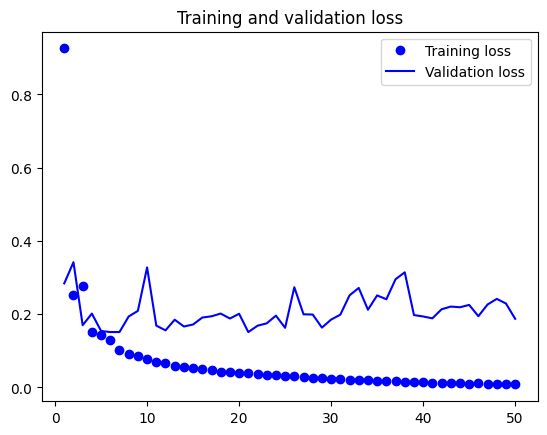

In [30]:
epochs = range(1, len(history_xception.history["loss"]) + 1)
loss = history_xception.history["loss"]
val_loss = history_xception.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

#### Evaluate the model

In [31]:
xception_finetune = keras.models.load_model("./models/xception_finetune.keras")

In [32]:
test_image = test_input_imgs
ground_truth_mask = test_targets
print(test_image.shape)

(70, 128, 128, 3)


In [33]:
mask_pred_2 = xception_finetune.predict(test_image)
mask_pred_2.shape

3/3 [==============================] - 3s 216ms/step


(70, 128, 128, 1)

In [34]:
binary_predictions_2 = (mask_pred_2 > 0.5).astype(np.uint8)
print(binary_predictions_2.shape)
print(ground_truth_mask.shape)

(70, 128, 128, 1)
(70, 128, 128, 1)


In [35]:
# print the predicted and ground truth classification label
print(np.unique(binary_predictions_2))
print(np.unique(ground_truth_mask))

[0 1]
[0 1]


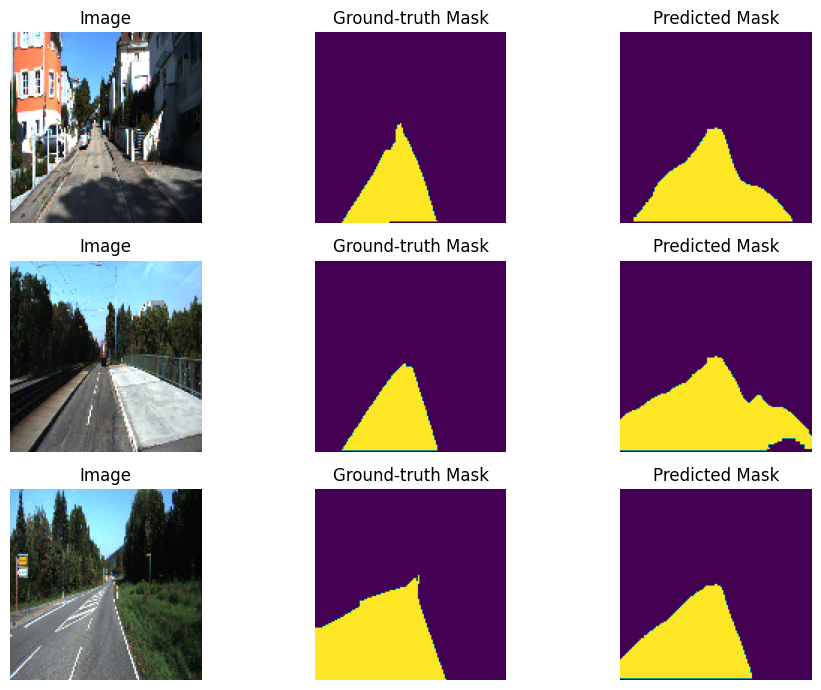

In [36]:
fig, ax = plt.subplots(3, 3, figsize=(10, 7))

indices = [0, 5, 10]

for plot_index, i in enumerate(indices):
    ax[plot_index, 0].imshow(test_image[i])
    ax[plot_index, 0].set_title("Image")
    ax[plot_index, 0].axis("off")


    ax[plot_index, 1].imshow(ground_truth_mask[i])
    ax[plot_index, 1].set_title("Ground-truth Mask")
    ax[plot_index, 1].axis("off")


    ax[plot_index, 2].imshow(binary_predictions_2[i])
    ax[plot_index, 2].set_title("Predicted Mask")
    ax[plot_index, 2].axis("off")

plt.tight_layout()
plt.show()

#### IOU

In [37]:
n_classes = 2
iou_calculator = MeanIoU(num_classes=n_classes)

iou_calculator.update_state(ground_truth_mask, binary_predictions_2)
print("Mean IoU =", iou_calculator.result().numpy())

Mean IoU = 0.8284987


### VGG16

Reference: https://github.com/hyoon1/CSCN8010/blob/main/dl_class_notebooks/05D_fine_tuning_vgg16.ipynb

#### Get the pretrained model

In [38]:
conv_vgg = keras.applications.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(128, 128, 3))

conv_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [42]:
conv_vgg.trainable = True
for layer in conv_vgg.layers[:-4]:
    layer.trainable = False

conv_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

#### Fine-tuning model

In [43]:
def get_model_vgg_finetune(img_size, num_classes):
    # Encoder substituting with the Xception model
    inputs = keras.Input(shape=img_size + (3,))
    x = keras.applications.vgg16.preprocess_input(inputs)
    x = conv_vgg(inputs)

    # Decoder
    x = layers.Conv2DTranspose(512, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(512, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", padding="same", strides=2)(x)

    # Output layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

img_size = (128, 128)
model_vgg_finetune = get_model_vgg_finetune(img_size=(img_size), num_classes=1)
model_vgg_finetune.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 conv2d_transpose_24 (Conv2D  (None, 4, 4, 512)        2359808   
 Transpose)                                                      
                                                                 
 conv2d_transpose_25 (Conv2D  (None, 8, 8, 512)        2359808   
 Transpose)                                                      
                                                                 
 conv2d_transpose_26 (Conv2D  (None, 8, 8, 256)        1179904   
 Transpose)                                                      
                                                           

#### Train and find the best model

In [44]:
model_vgg_finetune.compile(optimizer="rmsprop", loss="binary_crossentropy")

callbacks_vgg = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/vgg_finetune.keras",
        save_best_only=True,
        monitor="val_loss")
]

history_vgg = model_vgg_finetune.fit(X_train, y_train,
                                    epochs=50,
                                    callbacks=callbacks_vgg,
                                    batch_size=64,
                                    validation_data=(X_val, y_val))

Epoch 1/50
28/28 [==============================] - 14s 351ms/step - loss: 3.6783 - val_loss: 0.6453
Epoch 2/50
28/28 [==============================] - 5s 185ms/step - loss: 0.7413 - val_loss: 0.5872
Epoch 3/50
28/28 [==============================] - 5s 180ms/step - loss: 0.5708 - val_loss: 0.2850
Epoch 4/50
28/28 [==============================] - 5s 176ms/step - loss: 0.3005 - val_loss: 0.3268
Epoch 5/50
28/28 [==============================] - 5s 175ms/step - loss: 0.2566 - val_loss: 0.3247
Epoch 6/50
28/28 [==============================] - 5s 182ms/step - loss: 0.2538 - val_loss: 0.2064
Epoch 7/50
28/28 [==============================] - 5s 185ms/step - loss: 0.1810 - val_loss: 0.1418
Epoch 8/50
28/28 [==============================] - 5s 187ms/step - loss: 0.1590 - val_loss: 0.1536
Epoch 9/50
28/28 [==============================] - 5s 184ms/step - loss: 0.1321 - val_loss: 0.1031
Epoch 10/50
28/28 [==============================] - 5s 177ms/step - loss: 0.1113 - val_loss: 0.110

In [ ]:
epochs = range(1, len(history_vgg.history["loss"]) + 1)
loss = history_vgg.history["loss"]
val_loss = history_vgg.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

#### Evaluate the model

In [46]:
vgg_finetune = keras.models.load_model("./models/vgg_finetune.keras")

In [47]:
test_image = test_input_imgs
ground_truth_mask = test_targets
print(test_image.shape)

(70, 128, 128, 3)


In [48]:
mask_pred_3 = vgg_finetune.predict(test_image)
mask_pred_3.shape

3/3 [==============================] - 3s 393ms/step


(70, 128, 128, 1)

In [49]:
binary_predictions_3 = (mask_pred_3 > 0.5).astype(np.uint8)
print(binary_predictions_3.shape)
print(ground_truth_mask.shape)

(70, 128, 128, 1)
(70, 128, 128, 1)


In [50]:
# print the predicted and ground truth classification label
print(np.unique(binary_predictions_3))
print(np.unique(ground_truth_mask))

[0 1]
[0 1]


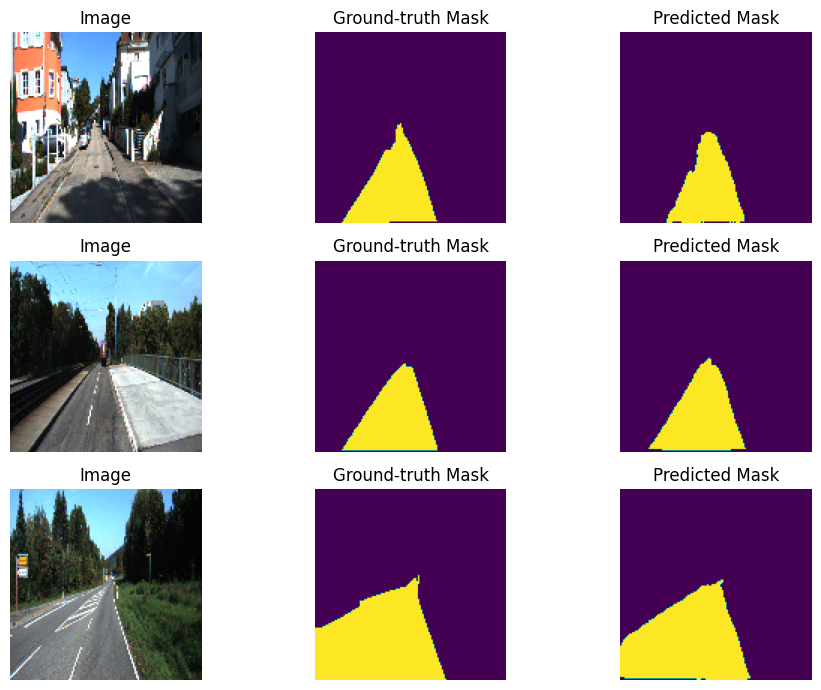

In [51]:
fig, ax = plt.subplots(3, 3, figsize=(10, 7))

indices = [0, 5, 10]

for plot_index, i in enumerate(indices):
    ax[plot_index, 0].imshow(test_image[i])
    ax[plot_index, 0].set_title("Image")
    ax[plot_index, 0].axis("off")


    ax[plot_index, 1].imshow(ground_truth_mask[i])
    ax[plot_index, 1].set_title("Ground-truth Mask")
    ax[plot_index, 1].axis("off")


    ax[plot_index, 2].imshow(binary_predictions_3[i])
    ax[plot_index, 2].set_title("Predicted Mask")
    ax[plot_index, 2].axis("off")

plt.tight_layout()
plt.show()

#### IOU

In [52]:
n_classes = 2
iou_calculator = MeanIoU(num_classes=n_classes)

iou_calculator.update_state(ground_truth_mask, binary_predictions_3)
print("Mean IoU =", iou_calculator.result().numpy())

Mean IoU = 0.88476634
